In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Verifying the connection to ClickHouse via pandahouse by sending a simple query: display the number of rows in the ldn_listings table

In [3]:
query = """
SELECT count()
FROM ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count()
0,85207


Let's extract the price data based on the type of housing from the table and calculate the 75th percentile

In [4]:
query_1 = """
SELECT toFloat32(replaceRegexpAll(price, '[$,]', '')) AS price, room_type
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""
df_1 = ph.read_clickhouse(query_1, connection=connection_default)
df_1.groupby('room_type').price.quantile(0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

Grouping the DataFrame by housing type and calculating the average for the price and rating

In [5]:
query_2 = """
SELECT 
    toFloat32(replaceRegexpAll(price, '[$,]', '')) AS price, 
    room_type, 
    review_scores_rating AS review_scores_rating
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""
df_2 = ph.read_clickhouse(query_2, connection=connection_default)
df_2 = df_2.dropna()
df_2['review_scores_rating'] = df_2['review_scores_rating'].astype(float)
df_2_mean = df_2.groupby('room_type')[['price', 'review_scores_rating']].mean()

Creating a scatter plot with the average price on the X-axis and the rating on the Y-axis, differentiated by housing type

<Axes: xlabel='price', ylabel='review_scores_rating'>

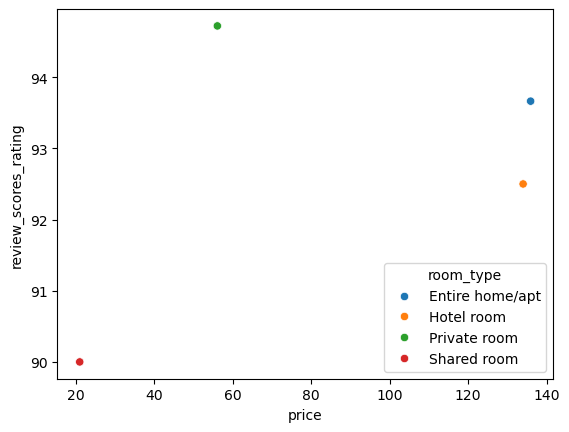

In [6]:
sns.scatterplot(data = df_2_mean, x='price', y='review_scores_rating', hue = 'room_type')

Let's check which verification methods the hosts offering various experiences have used

In [10]:
query_3 = """
SELECT DISTINCT host_id, host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
ORDER BY id
"""
df_3 = ph.read_clickhouse(query_3, connection=connection_default)
df_3.host_verifications = df_3.host_verifications.apply(lambda x: x.strip('[\']').split(', '))
df_3 = df_3.explode('host_verifications')
df_3.host_verifications.value_counts()

host_verifications
\'phone\'                    1361
\'email\'                    1345
\'reviews\'                  1309
\'government_id\'            1196
\'jumio\'                    1115
\'offline_government_id\'     469
\'work_email\'                279
\'facebook\'                  270
\'selfie\'                    252
\'identity_manual\'           227
\'manual_offline\'             70
\'google\'                     34
\'kba\'                        27
\'manual_online\'              16
\'sent_id\'                     6
Name: count, dtype: int64

Now let's see for how many listings and in which neighborhoods the hosts have specified experiences

In [8]:
query_4 = """
SELECT neighbourhood_cleansed, experiences_offered, count() AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df_4 = ph.read_clickhouse(query_4, connection=connection_default)
df_4 = df_4.pivot(index='neighbourhood_cleansed', columns = 'experiences_offered', values='experiences_count')

<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

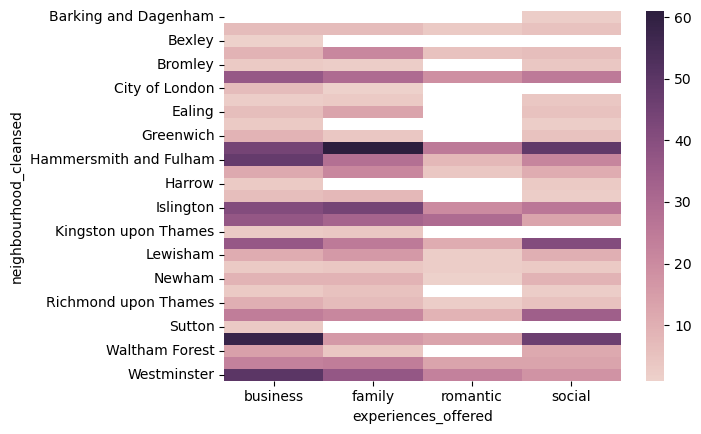

In [9]:
sns.heatmap(df_4, cmap=sns.cubehelix_palette(as_cmap=True))

Plotting the price distributions for each housing type

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_12048\2192146935.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_5.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
C:\Users\Ярослав\AppData\Local\Temp\ipykernel_12048\2192146935.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5

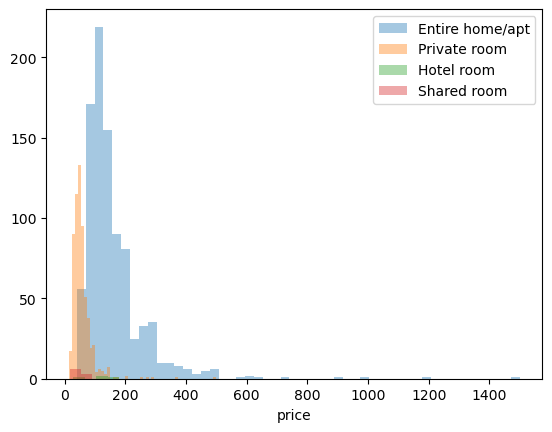

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_12048\2192146935.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df_5.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
C:\Users\Ярослав\AppData\Local\Temp\ipykernel_12048\2192146935.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

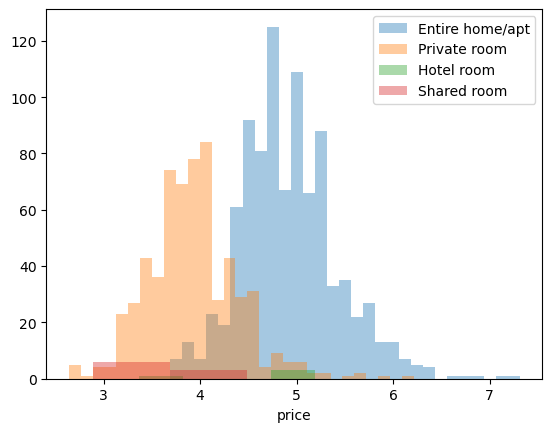

In [10]:
query_5 = """
SELECT toFloat32(replaceRegexpAll(price, '[$,]', '')) AS price, room_type
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_5 = ph.read_clickhouse(query_5, connection=connection_default)
sns.distplot(df_5.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_5.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_5.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_5.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()
sns.distplot(np.log(df_5.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_5.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_5.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_5.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

Let's create a plot showing the trend of average housing prices (Y-axis) by room type over the years (X-axis)

<Axes: xlabel='year', ylabel='price'>

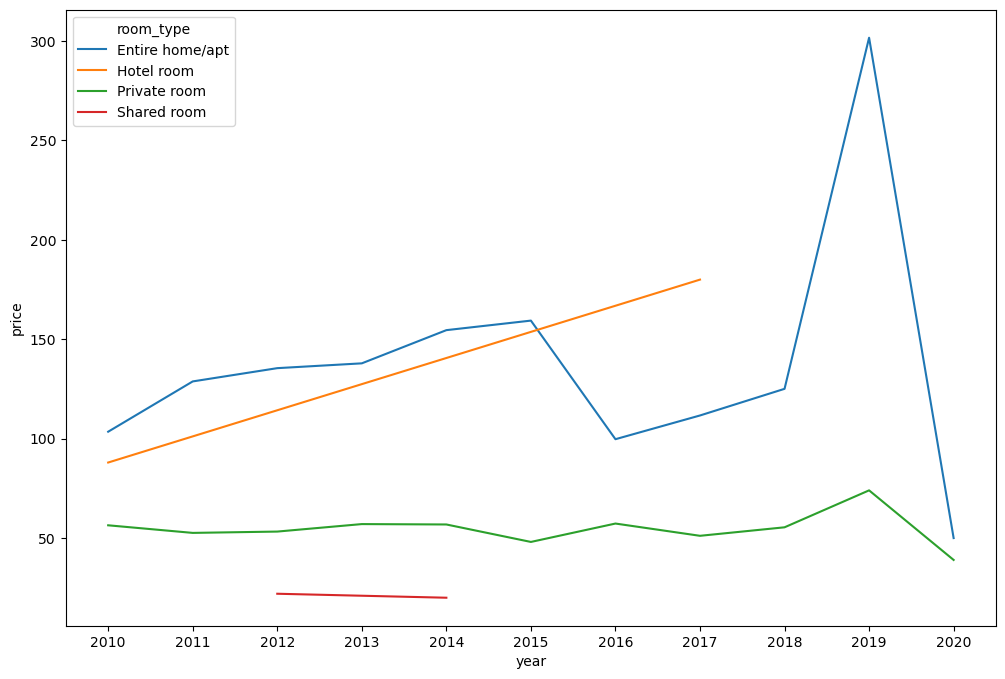

In [11]:
query_6 = """
SELECT toFloat32(replaceRegexpAll(price, '[$,]', '')) AS price, room_type, first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df_6 = ph.read_clickhouse(query_6, connection=connection_default)
df_6.first_review = df_6.first_review.apply(lambda x: x[:-6])
df_6 = df_6.rename(columns={'first_review':'year'})
df_6 = df_6.groupby(['year', 'room_type'], as_index=False).agg({'price':'mean'})
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_6, x='year', y='price', hue='room_type')